# Picking CSDNA origami and returning an array of origamis

In [51]:
# Necessary imports
from PIL import Image, ImageDraw
import numpy as np
import os
import glob
import cv2
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

try:
    from cuml.cluster import DBSCAN  # GPU accelerated version from RAPIDS
    use_gpu = True
    print("Using GPU for DBSCAN")
except ImportError:
    from sklearn.cluster import DBSCAN  # CPU version from scikit-learn
    use_gpu = False

# Function to process images, taking into account maximum dots per cluster
def process_images(input_path, group_radius=50, min_dots=100, max_dots=200, threshold=60, circle_color='green', circle_width=8):
    if os.path.isdir(input_path):
        image_paths = glob.glob(os.path.join(input_path, '*.png'))
    else:
        image_paths = [input_path]
    
    full_images = []
    group_images = []

    for image_path in image_paths:
        original_image = Image.open(image_path)
        image_array = np.array(original_image)

        # Find dots based on a threshold
        dots = np.where(np.all(image_array > threshold, axis=-1))
        dot_coordinates = np.array(list(zip(dots[1], dots[0])))

        # Clustering based on GPU or CPU availability
        if use_gpu:
            db = DBSCAN(eps=group_radius, min_samples=6, metric='euclidean', output_type='numpy').fit(dot_coordinates)
        else:
            db = DBSCAN(eps=group_radius, min_samples=6).fit(dot_coordinates)

        labels = db.labels_
        unique_labels = set(labels)

        grouped_dots = {label: [] for label in unique_labels if label != -1}

        # Assign dots to clusters
        for label, dot in zip(labels, dot_coordinates):
            if label != -1:
                grouped_dots[label].append(dot)

        groups_for_image = []
        # Filtering groups based on minimum and maximum size
        for idx, group in enumerate(grouped_dots.values()):
            if min_dots <= len(group) <= max_dots:
                xs, ys = zip(*group)
                min_x, max_x, min_y, max_y = min(xs), max(xs), min(ys), max(ys)
                bounding_box = [max(min_x - group_radius, 0), max(min_y - group_radius, 0),
                                min(max_x + group_radius, original_image.width), min(max_y + group_radius, original_image.height)]
                cropped_image = original_image.crop(bounding_box)
                groups_for_image.append(np.array(cropped_image))

        # Drawing ellipses around the clusters
        image_with_circles = original_image.copy()
        draw = ImageDraw.Draw(image_with_circles)
        for group in grouped_dots.values():
            if min_dots <= len(group) <= max_dots:
                xs, ys = zip(*group)
                min_x, max_x, min_y, max_y = min(xs), max(xs), min(ys), max(ys)
                draw.ellipse((min_x - group_radius, min_y - group_radius, max_x + group_radius, max_y + group_radius),
                             outline=circle_color, width=circle_width)

        full_images.append(np.array(image_with_circles))
        group_images.extend(groups_for_image)

    print(f"{len(image_paths)} images processed using {'GPU' if use_gpu else 'CPU'}")
    print(f"Total number of individual group images: {len(group_images)}")

    return full_images, group_images

def analyze_and_rotate_image(image_array):
    # Convert to grayscale
    gray_image = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)

    # Apply threshold to get rid of background
    _, thresholded_image = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresholded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # List to hold centers of spots
    centers = []
    
    # Loop through each contour
    for contour in contours:
        # Calculate image moments of the contour
        M = cv2.moments(contour)
        
        # Using the moments, calculate the centroid (center of the spot)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centers.append([cX, cY])
    
    if not centers:
        return image_array  # No centers found, return original image
    
    # Convert list of centers to a numpy array
    centers_array = np.array(centers)
    
    if len(np.unique(centers_array, axis=0)) >= 3:
        hull = ConvexHull(centers_array)
    else:
        # Not enough points to form a convex hull, return original image
        return image_array
    
    # Define a function to check if a point is close to a line segment
    def is_point_close_to_line(pt, line_start, line_end, threshold=5):
        line_magnitude = np.linalg.norm(line_end - line_start)
        distance = np.abs(np.cross(line_end-line_start, line_start-pt)) / line_magnitude
        return distance < threshold

    # Compute the length of each edge and check the distance of other points from the edge
    valid_edges = []
    for edge in hull.simplices:
        line_start, line_end = centers_array[edge[0]], centers_array[edge[1]]
        edge_length = np.linalg.norm(line_end - line_start)
        is_valid = True
        for point_index in range(len(centers_array)):
            if point_index not in edge:
                if is_point_close_to_line(centers_array[point_index], line_start, line_end):
                    is_valid = False
                    break
        if is_valid:
            valid_edges.append((edge_length, edge))

    if not valid_edges:
        return image_array  # No valid edges found, return original image
    
    # Find the longest valid edge
    longest_edge = max(valid_edges, key=lambda x: x[0])[1]
    
    # Calculate the rotation needed to align the longest edge with the horizontal
    point1, point2 = centers_array[longest_edge[0]], centers_array[longest_edge[1]]
    dx = point2[0] - point1[0]
    dy = (-1)*point2[1] - (-1)*point1[1]
    angle_of_rotation = np.arctan2(dy, dx)
    angle_to_horizontal = np.degrees(angle_of_rotation)
    rotation_angle = 180 - angle_to_horizontal if angle_to_horizontal < 0 else 360 - angle_to_horizontal
    rotation_center = ((point1[0] + point2[0]) / 2, (point1[1] + point2[1]) / 2)
    
    # Compute rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(rotation_center, rotation_angle, 1.0)
    (h, w) = gray_image.shape[:2]
    rotated_image = cv2.warpAffine(image_array, rotation_matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
    
    return rotated_image

In [52]:
#Testing with a sample image

1 images processed using CPU
Total number of individual group images: 621


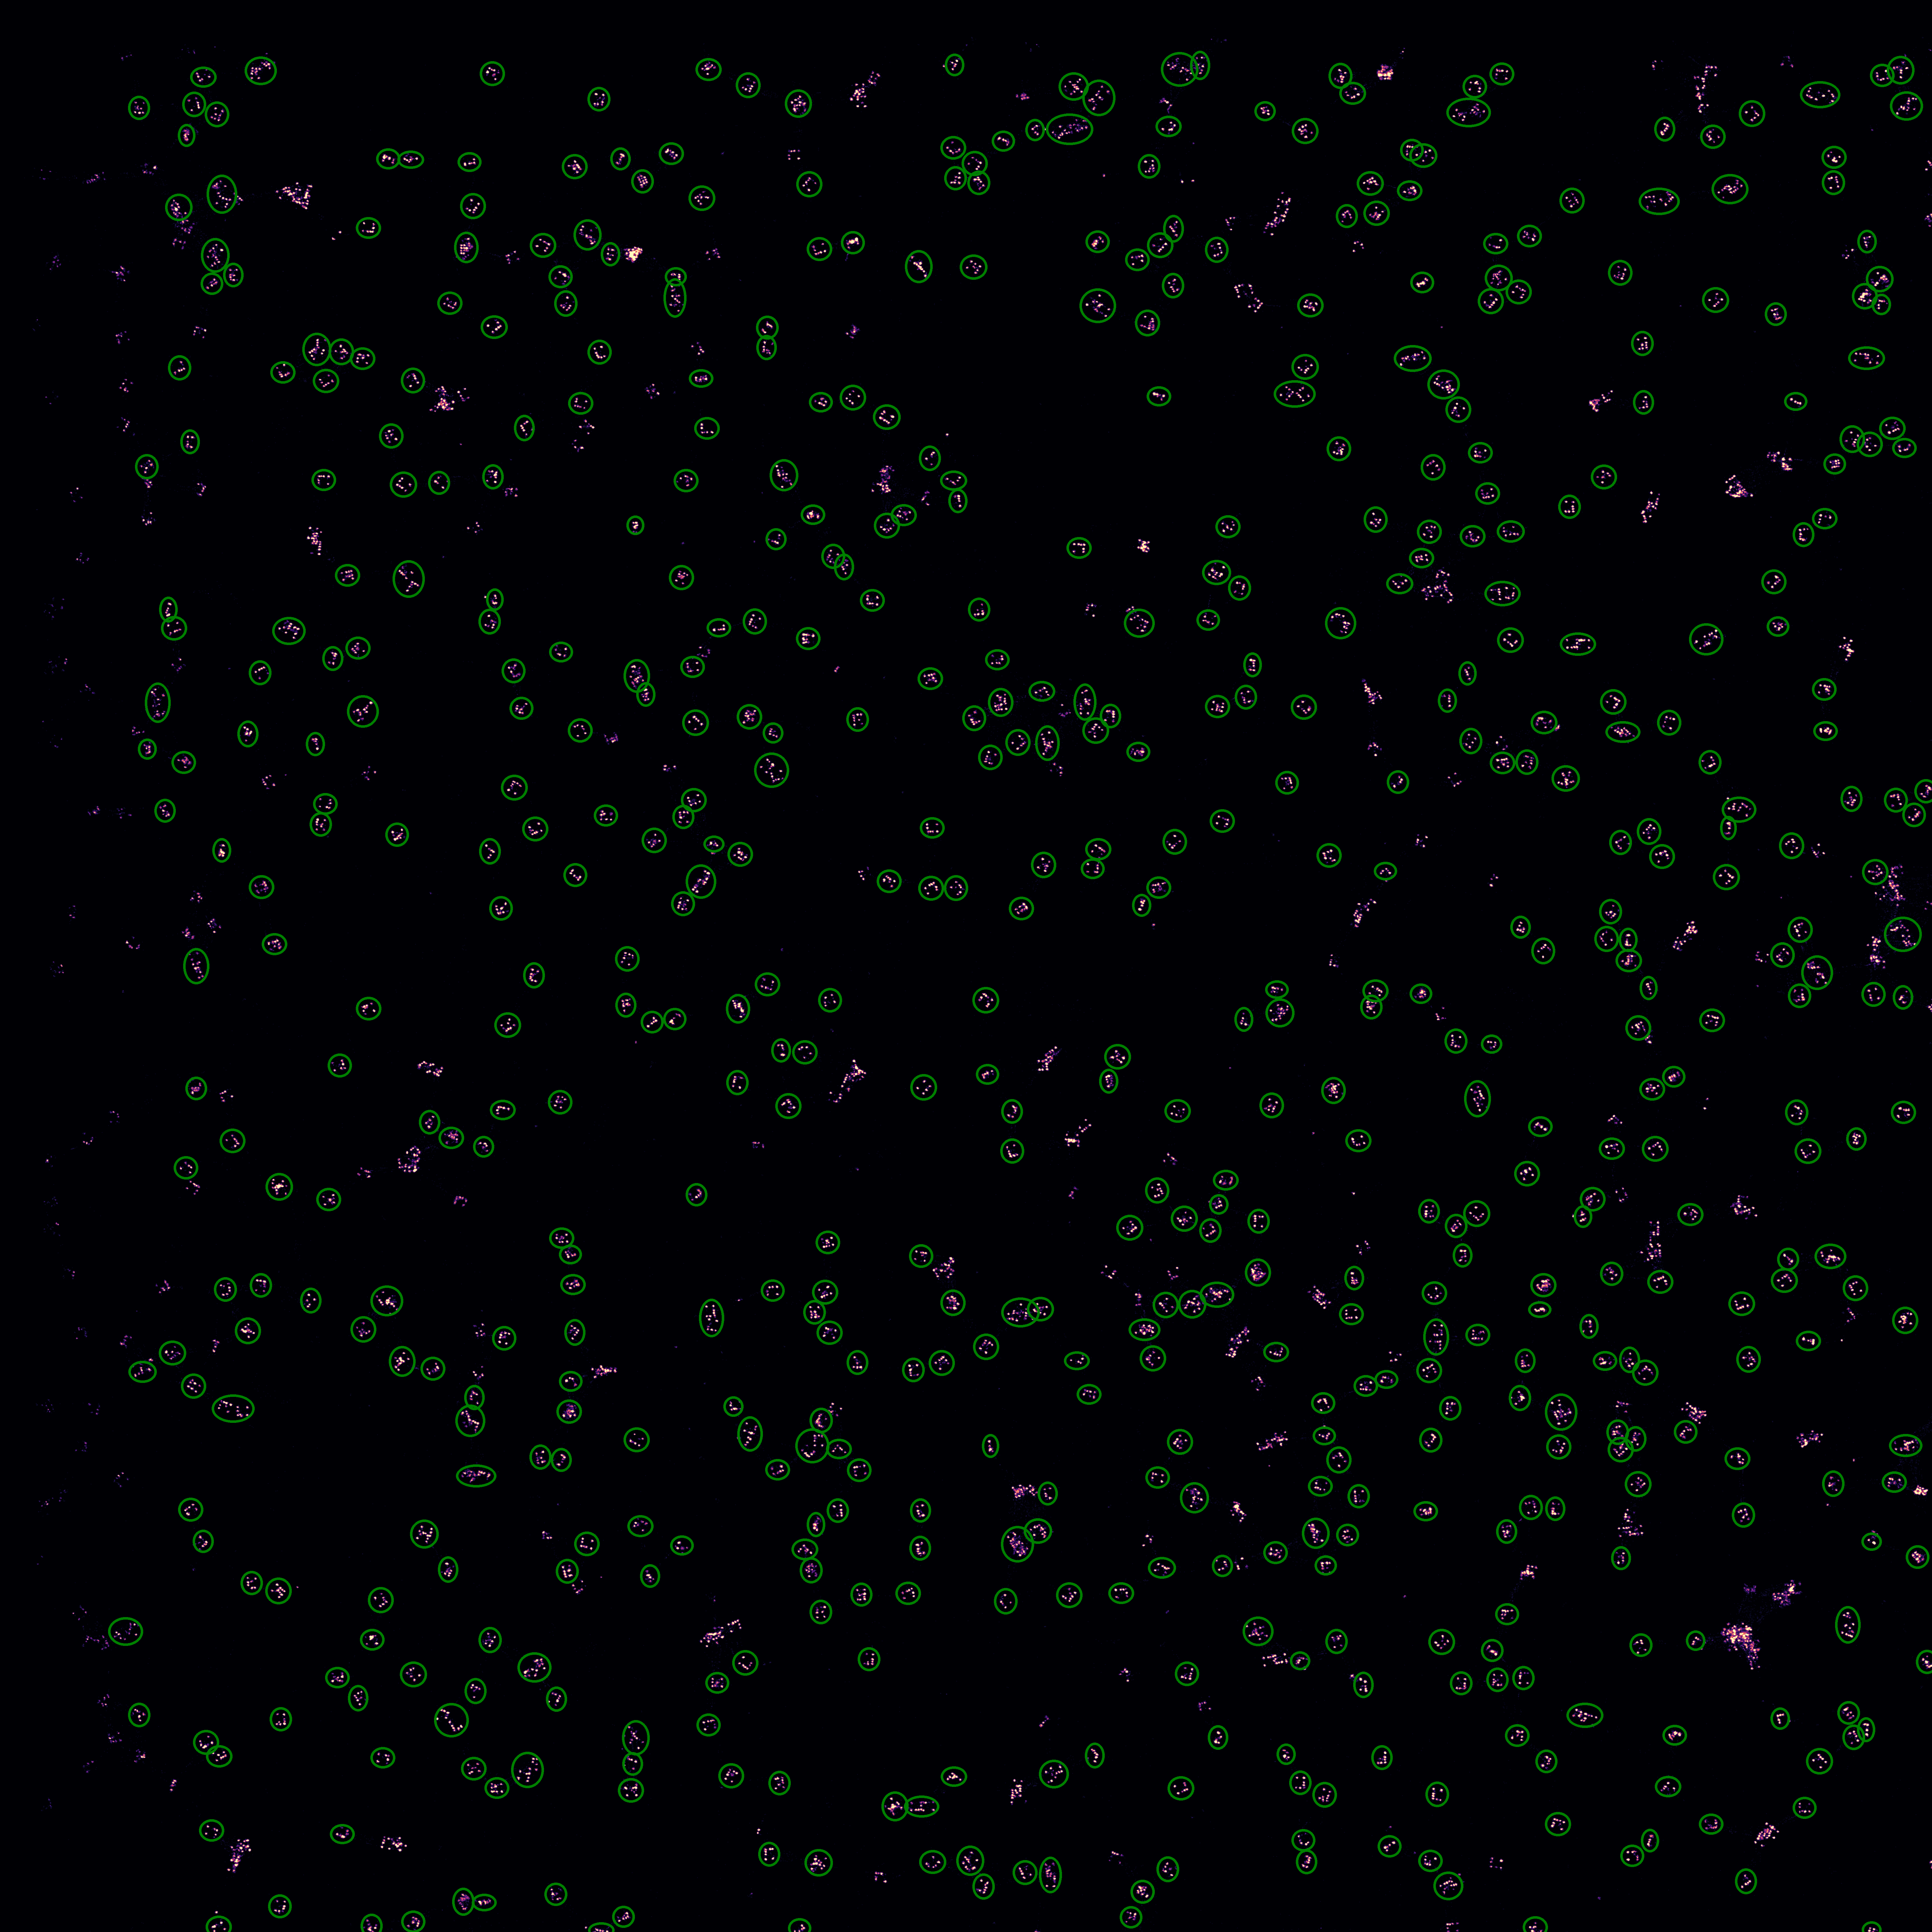

In [53]:
#runnin the function with the sample image
full_images, group_images = process_images('/workspaces/CSDNA/Testing code/Bordering Test/multi_acquisitions/000.png', group_radius=20, min_dots=100, max_dots=400, threshold=60, circle_color='green', circle_width=8)

#showing the full image and the group images
Image.fromarray(full_images[0])



## Using Bording.py to roatate all the origami

In [55]:
#running the function
for group_image in group_images:
    
    #convert the image to numpy array
    group_image_array = group_image
    
    #analyze and rotate the image
    rotated_image = analyze_and_rotate_image(group_image_array)
    
    #saving the rotated images to a folder called rotated_images with numbers as names
    cv2.imwrite(f"/workspaces/CSDNA/Testing code/Bordering Test/rotated_images/{len(os.listdir('/workspaces/CSDNA/Testing code/Bordering Test/rotated_images'))}.png", rotated_image)
    
